In [1]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.ticker import FuncFormatter
matplotlib.style.use('ggplot')
import sqlite3 
import warnings
import datetime


In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [190914,190921,190928,191005,191012,191019,191026,191102,191109,191116,191123,191130]


mtap = get_data(week_nums)

In [3]:
#mtap.head()

In [4]:
mtap.shape

(2471446, 11)

In [5]:
mtap.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
mtap.columns = [column.strip() for column in mtap.columns]
mtap.columns
#to remove the space in columns 

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:
mtap.DATE.value_counts().sort_index()

09/07/2019    29225
09/08/2019    29356
09/09/2019    29394
09/10/2019    29552
09/11/2019    29476
              ...  
11/25/2019    29962
11/26/2019    29235
11/27/2019    29655
11/28/2019    29265
11/29/2019    29156
Name: DATE, Length: 84, dtype: int64

In [8]:
mtap.DATE.dtypes

dtype('O')

In [9]:
mtap["DATE_TIME"] = pd.to_datetime(mtap.DATE + " " + mtap.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [10]:
mtap.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00


In [11]:
def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col= True))
    return pd.concat(dfs)
        
week_nums = [190914,190921,190928,191005,191012,191019,191026,191102,191109,191116,191123,191130]
mtap_2 = get_data_parse_dt(week_nums)
mtap_2.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2019-09-07 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566
1,2019-09-07 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574
2,2019-09-07 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603
3,2019-09-07 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676
4,2019-09-07 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725


In [12]:
print('Descriptions of entries:')
print(mtap['ENTRIES'].describe())
print('')
print('Descriptions of exits:')
print(mtap['EXITS'].describe())

Descriptions of entries:
count    2.471446e+06
mean     4.162529e+07
std      2.138568e+08
min      0.000000e+00
25%      2.998918e+05
50%      2.001598e+06
75%      6.634805e+06
max      2.129109e+09
Name: ENTRIES, dtype: float64

Descriptions of exits:
count    2.471446e+06
mean     3.431326e+07
std      1.972576e+08
min      0.000000e+00
25%      1.374730e+05
50%      1.165961e+06
75%      4.537504e+06
max      2.123791e+09
Name: EXITS, dtype: float64


In [13]:
mta_sorted = mtap.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
mta_sorted = mta_sorted.reset_index(drop = True)

turnstile_grouped = mta_sorted.groupby(["C/A", "UNIT", "SCP", "STATION"])

mta_sorted['entries_diff'] = turnstile_grouped['ENTRIES'].transform(pd.Series.diff)
mta_sorted['exits_diff'] = turnstile_grouped['EXITS'].transform(pd.Series.diff)

mta_sorted.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0


In [14]:
print('Descriptions of entries_diff:')
print(mta_sorted['entries_diff'].describe())
print('')
print('Descriptions of exits_diff:')
print(mta_sorted['exits_diff'].describe())

Descriptions of entries_diff:
count    2.466522e+06
mean    -1.325853e+02
std      3.558084e+06
min     -2.025847e+09
25%      9.000000e+00
50%      7.100000e+01
75%      2.360000e+02
max      2.037956e+09
Name: entries_diff, dtype: float64

Descriptions of exits_diff:
count    2.466522e+06
mean    -1.038261e+03
std      1.930707e+06
min     -1.907466e+09
25%      8.000000e+00
50%      5.200000e+01
75%      1.680000e+02
max      1.019396e+09
Name: exits_diff, dtype: float64


In [15]:
print('Number of negative entries_diff: %d' %len(mta_sorted['entries_diff'][mta_sorted['entries_diff'] < 0]))
print('Number of negative exits_diff: %d' %len(mta_sorted['exits_diff'][mta_sorted['exits_diff'] < 0]))
print('Number of unqiue C/A: %d' %len(mta_sorted["C/A"].unique()))
print('Number of unqiue UNIT: %d' %len(mta_sorted["UNIT"].unique()))
print('Number of unqiue SCP: %d' %len(mta_sorted["SCP"].unique()))
print('Number of unqiue STATIONS: %d' %len(mta_sorted["STATION"].unique()))
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries_diff'].isnull()]))

Number of negative entries_diff: 22066
Number of negative exits_diff: 16977
Number of unqiue C/A: 747
Number of unqiue UNIT: 469
Number of unqiue SCP: 225
Number of unqiue STATIONS: 378
Number of NaN rows: 4924


In [16]:
mta_sorted['entries_diff'] = mta_sorted['entries_diff'].fillna(0)
mta_sorted['exits_diff'] = mta_sorted['exits_diff'].fillna(0)
mta_sorted.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0


In [17]:
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries_diff'].isnull()])) # Check No. of NaN rows

Number of NaN rows: 0


In [18]:
mask = (mta_sorted['entries_diff'] >= 0) & (mta_sorted['exits_diff']>= 0)&(mta_sorted['entries_diff'] <= 3000)&(mta_sorted['exits_diff'] <= 3000)
# assuming that maximum 3000 passes through each turn turnstile
# removing the negative valuse of enntries and exits
mta_sorted = mta_sorted[mask] 
mta_sorted.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0


In [19]:
print('Descriptions of entries_diff:')
print(mta_sorted['entries_diff'].describe())
print('')
print('Descriptions of exits_diff:')
print(mta_sorted['exits_diff'].describe())

Descriptions of entries_diff:
count    2.441614e+06
mean     1.745953e+02
std      2.559001e+02
min      0.000000e+00
25%      9.000000e+00
50%      7.200000e+01
75%      2.370000e+02
max      2.999000e+03
Name: entries_diff, dtype: float64

Descriptions of exits_diff:
count    2.441614e+06
mean     1.397078e+02
std      2.336674e+02
min      0.000000e+00
25%      8.000000e+00
50%      5.300000e+01
75%      1.690000e+02
max      3.000000e+03
Name: exits_diff, dtype: float64


In [20]:
print('Number of negative entries_diff: %d' %len(mta_sorted['entries_diff'][mta_sorted['entries_diff'] < 0]))
print('Number of negative exits_diff: %d' %len(mta_sorted['exits_diff'][mta_sorted['exits_diff'] < 0]))
print('Number of unqiue C/A: %d' %len(mta_sorted["C/A"].unique()))
print('Number of unqiue UNIT: %d' %len(mta_sorted["UNIT"].unique()))
print('Number of unqiue SCP: %d' %len(mta_sorted["SCP"].unique()))
print('Number of unqiue STATION: %d' %len(mta_sorted["STATION"].unique()))
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries_diff'].isnull()]))

Number of negative entries_diff: 0
Number of negative exits_diff: 0
Number of unqiue C/A: 747
Number of unqiue UNIT: 469
Number of unqiue SCP: 225
Number of unqiue STATION: 378
Number of NaN rows: 0


In [21]:
mta_sorted.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0


In [22]:
# to get the most busiest stations (total number of entries and exits)
mta_h1 = mta_sorted[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE_TIME', 'DATE','TIME','entries_diff','exits_diff']]
mta_h1['busy'] = mta_h1['entries_diff'].values + mta_h1['exits_diff'].values

mta_h1.shape

<ipython-input-22-7b08c093092f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_h1['busy'] = mta_h1['entries_diff'].values + mta_h1['exits_diff'].values


(2441614, 10)

In [23]:
mta_h1.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,entries_diff,exits_diff,busy
0,A002,R051,02-00-00,59 ST,2019-09-07 00:00:00,09/07/2019,00:00:00,0.0,0.0,0.0
1,A002,R051,02-00-00,59 ST,2019-09-07 04:00:00,09/07/2019,04:00:00,21.0,8.0,29.0
2,A002,R051,02-00-00,59 ST,2019-09-07 08:00:00,09/07/2019,08:00:00,22.0,29.0,51.0
3,A002,R051,02-00-00,59 ST,2019-09-07 12:00:00,09/07/2019,12:00:00,138.0,73.0,211.0
4,A002,R051,02-00-00,59 ST,2019-09-07 16:00:00,09/07/2019,16:00:00,255.0,49.0,304.0


In [24]:
start_Sep = "2019-9-1"
end_Sep = "2019-9-30"

after_start_date = mta_sorted["DATE_TIME"] >= start_Sep
before_end_date = mta_sorted["DATE_TIME"] <= end_Sep
between_two_dates = after_start_date & before_end_date
Sep_MTA = mta_sorted.loc[between_two_dates]

Sep_MTA.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0


In [25]:
Sep_MTA['busy'] = Sep_MTA['entries_diff'].values + Sep_MTA['exits_diff'].values
Sep_MTA.head()

<ipython-input-25-8f55bcd94e25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sep_MTA['busy'] = Sep_MTA['entries_diff'].values + Sep_MTA['exits_diff'].values


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff,busy
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0,0.0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0,29.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0,211.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0,304.0


In [26]:
start_Oct = "2019-10-1"
end_Oct = "2019-10-31"

after_start_date = mta_sorted["DATE_TIME"] >= start_Oct
before_end_date = mta_sorted["DATE_TIME"] <= end_Oct
between_two_dates = after_start_date & before_end_date
oct_MTA = mta_sorted.loc[between_two_dates]

oct_MTA.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
144,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,00:00:00,REGULAR,7218487,2445129,2019-10-01 00:00:00,164.0,18.0
145,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,04:00:00,REGULAR,7218497,2445130,2019-10-01 04:00:00,10.0,1.0
146,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,08:00:00,REGULAR,7218531,2445224,2019-10-01 08:00:00,34.0,94.0
147,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,12:00:00,REGULAR,7218673,2445446,2019-10-01 12:00:00,142.0,222.0
148,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,16:00:00,REGULAR,7218945,2445496,2019-10-01 16:00:00,272.0,50.0


In [27]:
oct_MTA['busy'] = oct_MTA['entries_diff'].values + oct_MTA['exits_diff'].values
oct_MTA.head()

<ipython-input-27-8ed8a34dfd28>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oct_MTA['busy'] = oct_MTA['entries_diff'].values + oct_MTA['exits_diff'].values


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff,busy
144,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,00:00:00,REGULAR,7218487,2445129,2019-10-01 00:00:00,164.0,18.0,182.0
145,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,04:00:00,REGULAR,7218497,2445130,2019-10-01 04:00:00,10.0,1.0,11.0
146,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,08:00:00,REGULAR,7218531,2445224,2019-10-01 08:00:00,34.0,94.0,128.0
147,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,12:00:00,REGULAR,7218673,2445446,2019-10-01 12:00:00,142.0,222.0,364.0
148,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/01/2019,16:00:00,REGULAR,7218945,2445496,2019-10-01 16:00:00,272.0,50.0,322.0


In [28]:
start_Nov = "2019-11-1"
end_Nov = "2019-11-30"

after_start_date = mta_sorted["DATE_TIME"] >= start_Nov
before_end_date = mta_sorted["DATE_TIME"] <= end_Nov
between_two_dates = after_start_date & before_end_date
Nov_MTA = mta_sorted.loc[between_two_dates]

Nov_MTA.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff
330,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,00:00:00,REGULAR,7254773,2458184,2019-11-01 00:00:00,168.0,27.0
331,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,04:00:00,REGULAR,7254790,2458189,2019-11-01 04:00:00,17.0,5.0
332,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,08:00:00,REGULAR,7254830,2458292,2019-11-01 08:00:00,40.0,103.0
333,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,12:00:00,REGULAR,7254971,2458543,2019-11-01 12:00:00,141.0,251.0
334,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,16:00:00,REGULAR,7255307,2458611,2019-11-01 16:00:00,336.0,68.0


In [29]:
Nov_MTA['busy'] = Nov_MTA['entries_diff'].values + Nov_MTA['exits_diff'].values
Nov_MTA.head()

<ipython-input-29-b6e68489a7c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Nov_MTA['busy'] = Nov_MTA['entries_diff'].values + Nov_MTA['exits_diff'].values


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff,busy
330,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,00:00:00,REGULAR,7254773,2458184,2019-11-01 00:00:00,168.0,27.0,195.0
331,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,04:00:00,REGULAR,7254790,2458189,2019-11-01 04:00:00,17.0,5.0,22.0
332,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,08:00:00,REGULAR,7254830,2458292,2019-11-01 08:00:00,40.0,103.0,143.0
333,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,12:00:00,REGULAR,7254971,2458543,2019-11-01 12:00:00,141.0,251.0,392.0
334,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/01/2019,16:00:00,REGULAR,7255307,2458611,2019-11-01 16:00:00,336.0,68.0,404.0


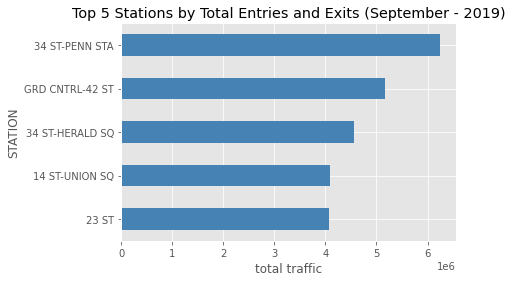

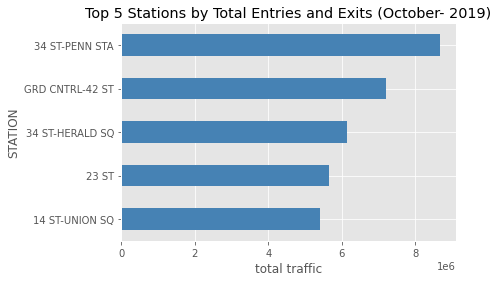

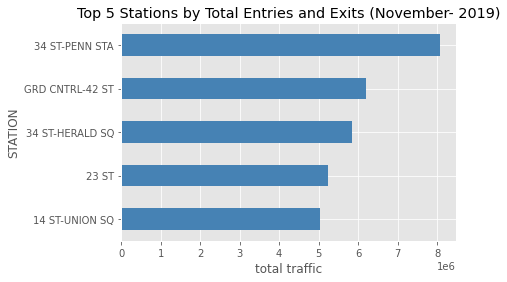

In [30]:
top_5 =Sep_MTA.groupby(['STATION']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(5)
fig, ax = plt.subplots(sharex=True, sharey=True) 
top_5.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Top 5 Stations by Total Entries and Exits (September - 2019)', xlabel='total traffic', ylabel='STATION')
ax.legend().set_visible(False)

top_5 =oct_MTA.groupby(['STATION']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(5)
fig, ax = plt.subplots( sharex=True, sharey=True) 
top_5.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Top 5 Stations by Total Entries and Exits (October- 2019)', xlabel='total traffic', ylabel='STATION')
ax.legend().set_visible(False)


top_5 =Nov_MTA.groupby(['STATION']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False).head(5)
fig, ax = plt.subplots( sharex=True, sharey=True)
top_5.sort_values(by = 'busy',ascending=True).plot(kind='barh', color ='steelblue',ax=ax)
ax.set(title='Top 5 Stations by Total Entries and Exits (November- 2019)', xlabel='total traffic', ylabel='STATION')
ax.legend().set_visible(False)

In [31]:
mta_penn = mta_h1[(mta_h1['STATION'] == '34 ST-PENN STA')]
mta_penn['TIME'] = pd.to_datetime(mta_penn['TIME'], format = '%H:%M:%S')
mta_penn_grouped = mta_penn.groupby(['TIME']).agg({'busy': sum}).sort_values(by = 'busy', ascending = False)
mta_penn_grouped.resample('60T',convention='end').sum().sort_values(by = 'busy', ascending = False).head()

<ipython-input-31-11a481117d55>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_penn['TIME'] = pd.to_datetime(mta_penn['TIME'], format = '%H:%M:%S')


,busy
TIME,
1900-01-01 20:00:00,3781420.0
1900-01-01 12:00:00,2880327.0
1900-01-01 16:00:00,2228165.0
1900-01-01 19:00:00,1806906.0
1900-01-01 11:00:00,1411194.0


In [32]:
mta_sorted['day_of_week'] = mta_sorted['DATE_TIME'].apply(lambda x : x.weekday())
mta_sorted.head()

<ipython-input-32-4abfb5b8b7be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_sorted['day_of_week'] = mta_sorted['DATE_TIME'].apply(lambda x : x.weekday())


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,entries_diff,exits_diff,day_of_week
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,00:00:00,REGULAR,7190495,2435566,2019-09-07 00:00:00,0.0,0.0,5
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,04:00:00,REGULAR,7190516,2435574,2019-09-07 04:00:00,21.0,8.0,5
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,08:00:00,REGULAR,7190538,2435603,2019-09-07 08:00:00,22.0,29.0,5
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,12:00:00,REGULAR,7190676,2435676,2019-09-07 12:00:00,138.0,73.0,5
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/07/2019,16:00:00,REGULAR,7190931,2435725,2019-09-07 16:00:00,255.0,49.0,5


In [33]:
wkday_dict = {'0':'Mon',
             '1':'Tues',
             '2':'Weds',
             '3':'Thurs',
             '4':'Fri',
             '5':'Sat',
             '6':'Sun'}
day_of_week = mta_sorted['day_of_week'].map(lambda x : str(x)).map(wkday_dict)

In [34]:

mta_h1['weekday'] = (mta_h1['DATE_TIME']).dt.day_name()
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mta_h1['weekday'] = pd.Categorical(mta_h1['weekday'], categories=weekdays, ordered = True)
mta_h1.head()

<ipython-input-34-89863e343fc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_h1['weekday'] = (mta_h1['DATE_TIME']).dt.day_name()
<ipython-input-34-89863e343fc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_h1['weekday'] = pd.Categorical(mta_h1['weekday'], categories=weekdays, ordered = True)


,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,entries_diff,exits_diff,busy,weekday
0,A002,R051,02-00-00,59 ST,2019-09-07 00:00:00,09/07/2019,00:00:00,0.0,0.0,0.0,Saturday
1,A002,R051,02-00-00,59 ST,2019-09-07 04:00:00,09/07/2019,04:00:00,21.0,8.0,29.0,Saturday
2,A002,R051,02-00-00,59 ST,2019-09-07 08:00:00,09/07/2019,08:00:00,22.0,29.0,51.0,Saturday
3,A002,R051,02-00-00,59 ST,2019-09-07 12:00:00,09/07/2019,12:00:00,138.0,73.0,211.0,Saturday
4,A002,R051,02-00-00,59 ST,2019-09-07 16:00:00,09/07/2019,16:00:00,255.0,49.0,304.0,Saturday


In [35]:
weekday_ave = mta_h1[['entries_diff', 'exits_diff', 'busy', 'weekday']].groupby('weekday').sum().reset_index().sort_values(by = 'weekday')

In [36]:
weekday_ave.head(7)

,weekday,entries_diff,exits_diff,busy
0,Monday,66731918.0,52636375.0,119368293.0
1,Tuesday,72003293.0,56698371.0,128701664.0
2,Wednesday,72592802.0,57273404.0,129866206.0
3,Thursday,70661838.0,55641926.0,126303764.0
4,Friday,70677762.0,56107833.0,126785595.0
5,Saturday,40980412.0,34652688.0,75633100.0
6,Sunday,32646213.0,28101970.0,60748183.0


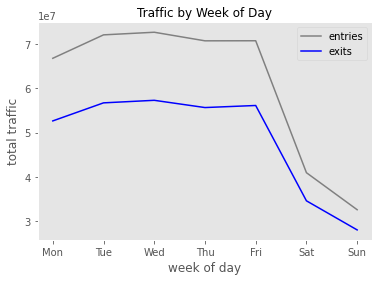

In [38]:
fig, ax1 = plt.subplots()

#p1 = weekday_ave['busy'].plot(kind='bar', color='steelblue', ax=ax1, label = 'entries')
#p1.legend(loc = 2)

plt.plot(weekday_ave['weekday'],weekday_ave['entries_diff'], color='gray', label = 'entries')
plt.plot(weekday_ave['weekday'],weekday_ave['exits_diff'], color='blue', label = 'exits')
#p2 = weekday_ave['exits_diff'].plot(kind='bar', color='gray', ax=ax1, label = 'exits')
#p2.legend(loc = 1)
plt.xticks((0,1,2,3,4,5,6),('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
ax1.set_xlabel('week of day')
ax1.set_ylabel('total traffic')
ax1.legend()
plt.grid(False)
plt.title('Traffic by Week of Day', size = 12) 
plt.show()